# This notebook allows for simple trajectory calculation, without any coordinate transforms

In [21]:
!pip3 install scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import slampy
import cv2
import numpy as np
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import rosbag
import numpy as np
from IPython.display import clear_output, display
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation as R
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [3]:
setting_file ='settings.yaml'

In [4]:
def load_image_from_msg(msg):
    im = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, -1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

In [5]:
def calc_trajectory(app:slampy.System, bag:rosbag.Bag, topics, timestamp_shift = 0):
    positions = []
    quaternions = []
    raw_outputs = []
    timestamps = []
    
    disp_current_frame_num = display('Frame num', display_id=True)
    disp_current_state = display('Current state',display_id=True)
    disp_conseq_ok = display('Consecutive ok frames',display_id=True)
    disp_conseq__not_ok = display('Consecutive not ok frames',display_id=True)
    disp_overall_ok = display('Overall ok frames',display_id=True)
    disp_overall_not_ok = display('Overall not ok frames',display_id=True)
    disp_current_pos = display('Current pos', display_id=True)
    
    current_frame_num = 0
    conseq_ok = 0
    conseq_not_ok = 1
    overall_ok = 0
    overall_not_ok = 0
    
    
    for topic, msg, t in bag.read_messages(topics=topics):

        current_frame_num += 1

        im = load_image_from_msg(msg)
        state = app.process_image_mono(im,t.to_sec() + timestamp_shift)

        if state == slampy.State.OK:
            conseq_not_ok = 0
            conseq_ok += 1
            overall_ok += 1

            new_pose = app.get_pose_to_target()
            pose_coordinates = new_pose[0:3, 3].flatten()
            pose_rotation = R.from_matrix(new_pose[:3, :3])

            positions.append(pose_coordinates)
            quaternions.append(pose_rotation.as_quat())
            raw_outputs.append(new_pose)
            timestamps.append(t.to_nsec())
            disp_current_pos.update(pose_coordinates)
        else:
            conseq_not_ok += 1
            conseq_ok = 0
            overall_not_ok += 1

        disp_current_frame_num.update("Frame num: " + str(current_frame_num))
        disp_current_state.update(state)
        disp_conseq_ok.update("Consecutive ok: " + str(conseq_ok))
        disp_conseq__not_ok.update("Consecutive not ok: " + str(conseq_not_ok))
        disp_overall_ok.update("Overall ok: " + str(overall_ok))
        disp_overall_not_ok.update("Overall not ok: " + str(overall_not_ok))
    print("Overall ok: " + str(overall_ok))
    print("Overall not ok: " + str(overall_not_ok))
    return positions, quaternions, raw_outputs

In [6]:
app = slampy.System(setting_file,slampy.Sensor.MONOCULAR)

the input sensor select is MONOCULAR


In [7]:
plt.plot([i[2] for i in p], [j[0] for j in p])
plt.axis('equal')
plt.show()

NameError: name 'p' is not defined

In [8]:
def upper_neighbor(df, value, colname):
    return df[df[colname] > value][colname].idxmin()

In [9]:
def calculate_combined_data(cam_outputs:list, threshold=0.3, conseq_frames=10, data_col_name='output'):
    cams = []
    indices = []
    tstamps = []
    first_res = [i.iloc[0][data_col_name] for i in cam_outputs]
    current_cam = first_res.index(max(first_res))
    current_index = -1
    current_res = 0
    prone_to_change = 0
    while True:
        cams.append(current_cam)
        indices.append(current_index)
        tstamps.append(cam_outputs[current_cam].iloc[current_index]['nsecs_str'])
        try:
            current_index += 1
            current_df = cam_outputs[current_cam].iloc[current_index]
        except IndexError:
            break
        if current_df[data_col_name] < threshold:
            if prone_to_change < conseq_frames:
                prone_to_change += 1
            else:
                next_indices = [upper_neighbor(i, current_df.nsecs, 'nsecs') for i in cam_outputs]
                next_dfs = [cam_outputs[i].iloc[next_indices[i]] for i in range(len(cam_outputs))]
                next_outputs = [i.output for i in next_dfs]
                next_best_cam = next_outputs.index(max(next_outputs))
                if not current_cam == next_best_cam:
                    current_cam = next_best_cam
                    current_index = next_indices[next_best_cam] - 1
                prone_to_change = 0
        else:
            prone_to_change = max([0, prone_to_change - 1])
    
    combined_data = pd.DataFrame()
    combined_data["cam"] = cams
    combined_data["tstamp"] = tstamps
    return combined_data

In [10]:
# Calculate position and orientation of robot given the pos and orientation of single camera
def calc_robot_position(sv, rq, cam_num, pos, quat):
    robot_shift_vec = quat.apply(sv[cam_num])
    new_quat = quat * rq[cam_num]
    robot_pos = pos + robot_shift_vec
    return robot_pos, new_quat

# Calculate position and orientation of any camera given the pos and orientation of robot
def calc_cam_position(sv, rq, cam_num, pos, quat):
    new_quat = rq[cam_num].inv() * quat
    cam_shift_vec = new_quat.apply(sv[cam_num])
    cam_pos = pos - cam_shift_vec
    # cam_pos = pos
    return cam_pos, new_quat

In [11]:
from numpy import sin, cos, pi
# Shift vectors from camera to robot center
shift_vecs = [
    np.array([-37.477 / 100, 7.778 / 100, 0]),
    np.array([-37.477 / 100, -7.778 / 100, 0]),
    np.array([-21. / 100, 0, 0]),
    np.array([-37.477 / 100, 7.778 / 100, 0]),
    np.array([-37.477 / 100, -7.778 / 100, 0]),
    np.array([-21. / 100, 0, 0])
]
# Rotation quaternions from camera to lidar frame
rot_quats = [
    R.from_quat([0, 0, sin(-pi/8), cos(-pi/8)]),
    R.from_quat([0, 0, sin(pi/8), cos(pi/8)]),
    R.from_quat([0, 0, sin(pi/4), cos(pi/4)]),
    R.from_quat([0, 0, sin(3*pi/8), cos(3*pi/8)]),
    R.from_quat([0, 0, sin(-3*pi/8), cos(-3*pi/8)]),
    R.from_quat([0, 0, sin(-pi/4), cos(-pi/4)])
]

In [12]:
def calc_trajectory_orb3_combined(app:slampy.System, bag:rosbag.Bag, frames_df):
    positions = []
    quaternions = []
    raw_outputs = []
    timestamps = []
    
    disp_current_frame_num = display('Frame num', display_id=True)
    disp_current_state = display('Current state',display_id=True)
    disp_conseq_ok = display('Consecutive ok frames',display_id=True)
    disp_conseq__not_ok = display('Consecutive not ok frames',display_id=True)
    disp_overall_ok = display('Overall ok frames',display_id=True)
    disp_overall_not_ok = display('Overall not ok frames',display_id=True)
    disp_camera_num = display('Camera number',display_id=True)
    disp_current_pos = display('Current pos', display_id=True)

    
    current_frame_num = 0
    conseq_ok = 0
    conseq_not_ok = 1
    overall_ok = 0
    overall_not_ok = 0
    
    last_known_robot_pos = np.array([0,0,0])
    last_known_robot_rot = R.from_rotvec(np.array([0,0,0]))
    
    for topic, msg, t in bag.read_messages(topics=["/cam0/image_raw",
                                                   "/cam1/image_raw",
                                                   "/cam2/image_raw",
                                                   "/cam3/image_raw",
                                                   "/cam4/image_raw",
                                                   "/cam5/image_raw",]):
        cam_num = int(topic[4])
        t_nsec = str(t.to_nsec())
        if ((frames_df['cam'] == cam_num) & (frames_df['tstamp'] == t_nsec)).any():
            
            im = load_image_from_msg(msg)
            state = app.process_image_mono(im,t.to_sec())

            current_frame_num += 1

            if state == slampy.State.OK:
                conseq_not_ok = 0
                conseq_ok += 1
                overall_ok += 1
                
                new_pose = app.get_pose_to_target()
                raw_p = new_pose[0:3, 3].flatten()[[2,0,1]]
                raw_r = R.from_quat(R.from_matrix(new_pose[:3, :3]).as_quat()[[2,0,1,3]])
                new_p, new_r = calc_robot_position(shift_vecs, rot_quats, cam_num, raw_p, raw_r)
                
                positions.append(new_p)
                quaternions.append(new_r.as_quat())
                raw_outputs.append(new_pose)
                timestamps.append(t.to_nsec())
                disp_current_pos.update(new_p)

            else:
                conseq_not_ok += 1
                conseq_ok = 0
                overall_not_ok += 1

            disp_current_frame_num.update("Frame num: " + str(current_frame_num))
            disp_current_state.update(state)
            disp_conseq_ok.update("Consecutive ok: " + str(conseq_ok))
            disp_conseq__not_ok.update("Consecutive not ok: " + str(conseq_not_ok))
            disp_overall_ok.update("Overall ok: " + str(overall_ok))
            disp_overall_not_ok.update("Overall not ok: " + str(overall_not_ok))
            disp_camera_num.update("Camera number: " + str(cam_num))
    print("Overall ok: " + str(overall_ok))
    print("Overall not ok: " + str(overall_not_ok))
    return positions, quaternions, raw_outputs, timestamps

In [ ]:
files = ["orb-classification/notebooks/outputs/regressor/2022-06-09/cam0.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam1.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam2.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam3.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam4.csv",
         "orb-classification/notebooks/outputs/regressor/2022-06-09/cam5.csv"]
c = []
for f in files:
    c.append(pd.read_csv(f, header=0))
for current_c in c:
    current_c['nsecs_str'] = current_c.nsecs.astype(str)

combined_data = calculate_combined_data(c, threshold=0.95)
bag = rosbag.Bag("/hermesbot/datasets/with_lidar_20220609/cameras.bag", 'r')

In [34]:
app = slampy.System(setting_file,slampy.Sensor.MONOCULAR)

the input sensor select is MONOCULAR


In [35]:
p,q,r,t = calc_trajectory_orb3_combined(app, bag, combined_data)

'Frame num: 3814'

<State.LOST: 2>

'Consecutive ok: 0'

'Consecutive not ok: 1'

'Overall ok: 3476'

'Overall not ok: 338'

'Camera number: 0'

array([ 0.14355279,  1.31688179, -0.18077226])

Overall ok: 3476
Overall not ok: 338


In [43]:
app.reset()

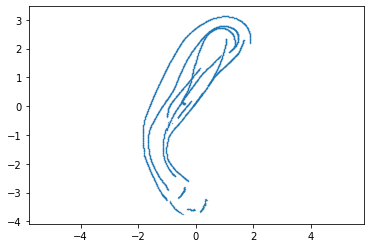

In [40]:
thresh = 199
plt.scatter([i[0] for i in p], [j[1] for j in p], s=0.1)
plt.axis('equal')
plt.show()

In [44]:
p_df = pd.DataFrame(np.array(p), columns=["x", "y", "z"])
r_df = pd.DataFrame(np.array(q), columns=["qx", "qy", "qz", "qw"])
t_df = pd.DataFrame(np.array(t), columns=["t"])

In [49]:
df = pd.concat((t_df, p_df, r_df), axis=1)

In [50]:
df.to_csv('results/2022-06-09_orbslam2_thr0.95_nomap.csv', index=False)

In [51]:
import pickle
with open('results/2022-06-09_orbslam2_thr0.95_nomap.pickle', 'wb') as f:
    pickle.dump(r, f)

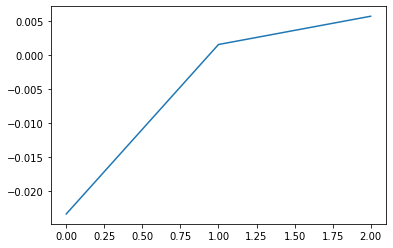

In [54]:
plt.plot(p[:][0])

array([-0.02333579, -0.02993761, -0.03457652, ..., -8.031144  ,
       -8.060414  , -8.064064  ], dtype=float32)

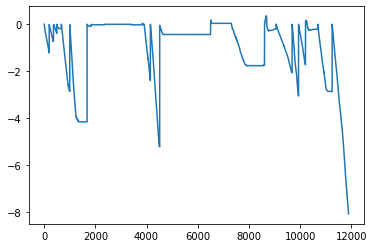

In [63]:
plt.plot(np.array(p)[:, 0])

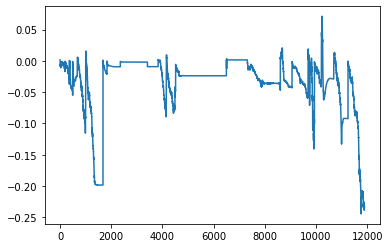

In [64]:
plt.plot(np.array(p)[:, 1])

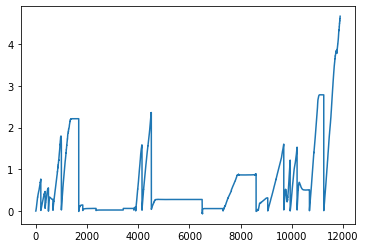

In [65]:
plt.plot(np.array(p)[:, 2])

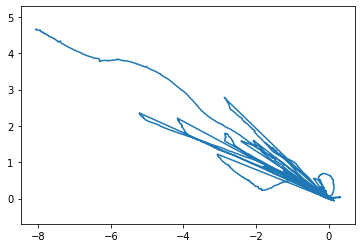

In [46]:
plt.plot([i[0] for i in p], [j[2] for j in p])
plt.axis('equal')
plt.show()

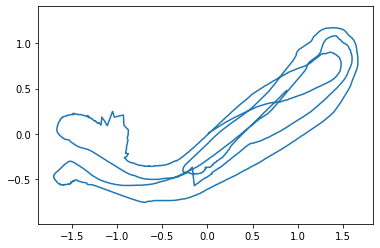

In [9]:
plt.plot([i[0] for i in p], [j[2] for j in p])
plt.axis('equal')
plt.show()

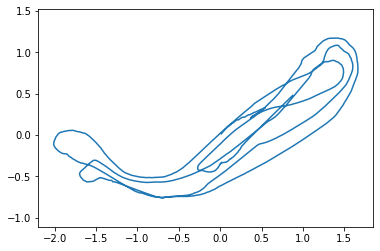

In [11]:
plt.plot([i[0] for i in p], [j[2] for j in p])
plt.axis('equal')
plt.show()

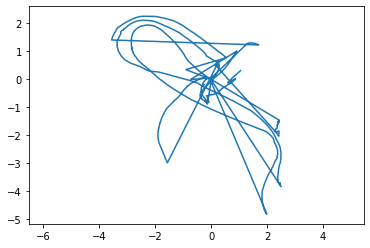

In [13]:
plt.plot([i[0] for i in p], [j[2] for j in p])
plt.axis('equal')
plt.show()

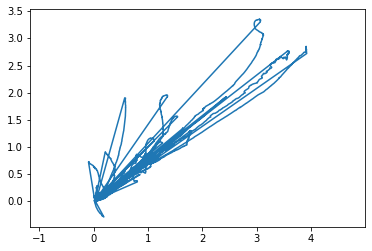

In [28]:
plt.plot([i[0] for i in p], [j[2] for j in p])
plt.axis('equal')
plt.show()

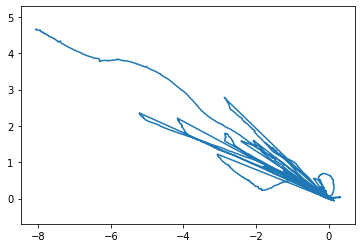

In [30]:
plt.plot([i[0] for i in p], [j[2] for j in p])
plt.axis('equal')
plt.show()